<a href="https://colab.research.google.com/github/royam0820/Notebooks/blob/master/Copy_of_v3_1_lesson1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - Pets Classification


## Lesson 1 -   Notes

[course repo](https://github.com/fastai/course-v3)

[from hiromis](https://github.com/hiromis/notes/blob/master/Lesson1.md)

[from poonav](https://forums.fast.ai/t/deep-learning-lesson-1-notes/27748)

[discussion thread](https://forums.fast.ai/t/lesson-1-discussion/27332)

[video timeline](https://forums.fast.ai/t/lesson-1-official-resources-and-updates/27936)

[fastai-doc](https://docs.fast.ai/)

## What's your pet

Welcome to lesson 1! For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `00_notebook_tutorial.ipynb`. 

In this lesson we will build our first image classifier from scratch, and see if we can achieve world-class results. Let's dive in!

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these **37 distinct categories**. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

In [0]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [0]:
#path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

In [0]:
path = untar_data(URLs.PETS, dest='/content/sample_data'); path

PosixPath('/content/sample_data/oxford-iiit-pet')

NOTE: for the `untar_data` instruction, you can give a full path info.  Exemple:

`# path = untar_data(URLs.PETS,fname='/content/drive/My Drive/FastAIPart1V3/data/oxford-iiit-pet.tgz',dest='/content/drive/My Drive/FastAIPar'`

In [0]:
path.ls()

[PosixPath('/content/sample_data/oxford-iiit-pet/images'),
 PosixPath('/content/sample_data/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

NOTE:  the `/`(slash) operator is Python 3 operator which is part of the pathlib library. It let you  basically create sub paths like done above; also, It doesn't matter if you're on Windows, Linux, or Mac. It is always going to work exactly the same way.

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/sample_data/oxford-iiit-pet/images/Russian_Blue_145.jpg'),
 PosixPath('/content/sample_data/oxford-iiit-pet/images/american_pit_bull_terrier_14.jpg'),
 PosixPath('/content/sample_data/oxford-iiit-pet/images/english_cocker_spaniel_96.jpg'),
 PosixPath('/content/sample_data/oxford-iiit-pet/images/havanese_28.jpg'),
 PosixPath('/content/sample_data/oxford-iiit-pet/images/staffordshire_bull_terrier_21.jpg')]

In [0]:
np.random.seed(2)
pat = re.compile(r'/([^/]+)_\d+.jpg$')

NOTE: `np.random.seed(2)`  we need to define a seed that makes the random numbers predictable. When the value is reset, the same numbers will appear every time. If we do not assign the seed, NumPy automatically selects a random seed value based on the system's random number generator device or on the clock.

`pat = re.compile(r'/([^/]+)_\d+.jpg$')` is a regular expression that extract the label for this dataset.

Let’s deconstruct this regex pattern, ` /([^/]+)_\d+.jpg$` by reading it backward:

**Expression - 	Explanation**
- `$	` end of search
- `.jpg`	last chars to be found in the search string, also right file format checking
- `\d`	numerical digits, ‘+’ sign denotes can be one or more of them
- `_`	should come before the start of digits
- `()`	denotes a group of characters
- `[]`	denotes another subgroup if characters in the previous group
- `^/	‘^’` denotes negation, so ‘+’ says all other chars except ‘/’
- `( [ ^/ ] + )`	searches all characters except ‘/’
- `/`	first ‘/’ in regex says, end of search
- `r`	The string should be a raw string. Otherwise, \d would have to be written as \\d so that Python doesn’t interpret it to be a special character.
So, this regex pattern will give us a string:

`Abyssinian_1.jpg`

Further, by using the fact that the actual name of the breed is in the first parenthesized group of the regular expression, the actual breed name:

`Abyssinian`

can be obtained by using ‘.group(1)’ wherever the search on the regular expression is performed.

For further infos on regular expressions see the section below.



In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

NOTE:  [`ImageDataBunch.from_name_re`](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_name_re) is going to return a DataBunch object. In fastai, everything you model with is going to be a DataBunch object. Basically DataBunch object contains 2 or 3 datasets - it contains your training data, validation data, and optionally test data. For each of those, it contains your images and your labels, your texts and your labels, or your tabular data and your labels, or so forth. And that all sits there in this one place(i.e. data).

`from_name_re()` is a factory method to extract labels using regular expressions.

`pat` references your regular expression pattern.

`ds_tfms` indicates transformations which we will be applied to images on the fly. transforms also changes all the image sizes to 224 X 224 since on these sizes our architecture resnet34 has been trained on. Also, all the images get centered, cropped and zoomed a little bit by transformation functions.

`size` = image size (224px x 224px)

`bs` is the batch size; it indicates the number of images the computer is processing at once. You might run out of memory (ram) if the `bs` is too big. Start with '64' if using a GPU and '32' our '16' if on CPU. 

`normalize(imagenet_stats)`: Since we are using a pre-trained model on **ImageNet**, then the normalization that was used to pre-train ImageNet has been applied to the new data (pets). `normalize` will apply a mean of 0 and a standard deviation of 1.

Pixel values of images range from 0 to 255. Images generally contain 3 color channels (Red, Green, and Blue). Sometimes some channels will be bright, some might be dull. Some might vary so much and some might not vary at all. It really helps to train a model if all those 3 channels have got pixel values with a mean of 0 and a standard deviation of 1. Normalization simply does that.

**Advice:** If you have trouble while training a model one thing to verify is that whether you have normalized the data properly.




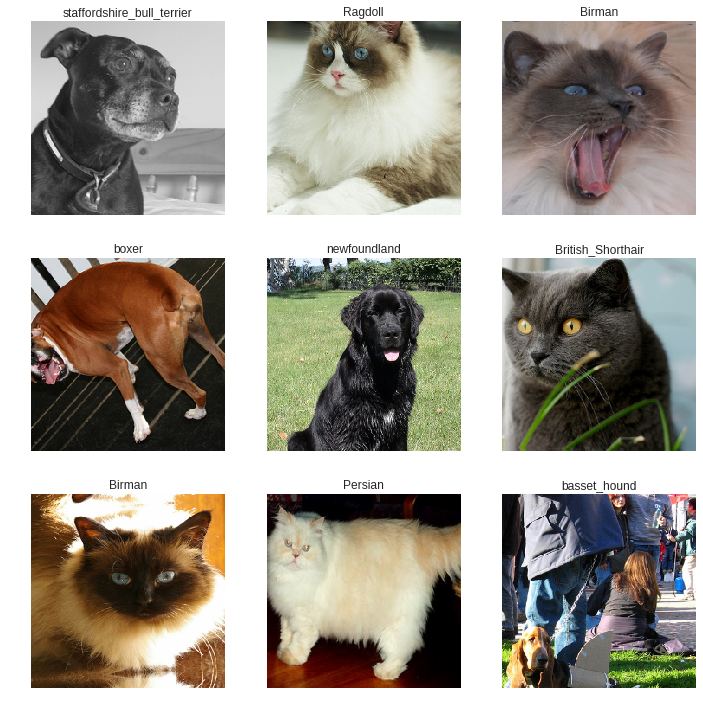

In [0]:
data.show_batch(rows=3, figsize=(10,10))

NOTE: It is really important to look at your data and check if everything looks fine.
Sometimes images can have text on it, or they might be occluded by some other object, or some of them might be rotated in odd ways.


In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

NOTE:  the `ImageDataBunch` give `data.classes` that lists down all the classes you have.  Also, it is important to check the total number of classes you have.  An indeed, you do have 37 classes in the oxford pet dataset.
**The `data.c` property also gives the number of classes.**

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

## Understanding CNN 


In [0]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate)
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 82489304.26it/s]


NOTE:  `create_cnn` method resides in **fastai.vision.learner class**.
In fastai, the model is trained by a learner, create_cnn takes few parameters, first the DataBunch data object, then model resnet34, the last thing to pass is the list of metrics.

When you call create_cnn first time, it downloads resnet34 pre-trained weights.

Pre-trained means this particular model has been already trained for the particular task, and that task is it is been trained on 1 and half million pictures of 1000 different categories of objects like plants, animals, people, cars etc. using image dataset called Imagenet 11.

So we don’t necessarily start with a model that knows nothing about images, but we start with knowledge of images of 1000 categories.

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time


NOTE:  [The 1cycle Policy](https://sgugger.github.io/the-1cycle-policy.html) - [the 1cycle Policy Paper](https://arxiv.org/pdf/1311.2901.pdf)

`fit_one_cycle`: Smith showed that if we very slowly increase the learning rate during training, whilst at the same time decreasing momentum, we can train at extremely high learning rates, thus avoiding over-fitting, and training in far fewer epochs.

`fit_one_cycle` method fits a model following one cycle policy.
It accepts `cycle_len` which is an integer describing how many times you want to pass through the complete dataset. Each time the model sees a picture, it keeps getting better. It gonna take a lot of time. But if you show images too many times, the model will learn to recognize that image alone. In machine learning, this is called overfitting. (memorizing).

`max_lr` is maximum learning rate, `moms` are momentum and `wd` is weight decay we will learn about all these parameters in subsequent lectures.

We can tune `cycle_len` as much as we want till we get better results.

For now, 4 is a pretty good number. As you can see from the  error_rate column in output,  after 4 epochs (4 times complete pass through data) we have got 6% error. Which represents 94% accuracy, meaning that we have identified the exact pet breeds of those 37 dog and cat breeds.  

In [0]:
learn.save('/content/sample_data/stage-1') 

NOTE:  this will save the model as `.pth` format, which is Pytorch’s default serialization method.  Models will get saved into your local dir in **/models** folder
Since different model’s weights should be saved separately we use local directories instead of a global one.

If we want to play around more with hyperparameters, we should save weights.

In [0]:
from google.colab import files

files.download('/content/sample_data/stage-1.pth')

## Analyzing the Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [21]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

NOTE:  The class `ClassificationInterpretation` has methods for creating a confusion matrix as well as plotting misclassified images.

For this class, we need pass the `learn` object, which knows 2 things the data and the model.  The model, here, is not just the architecture but also the  trained model with weights.

Let's look first at the misclassified images.

### Top losses

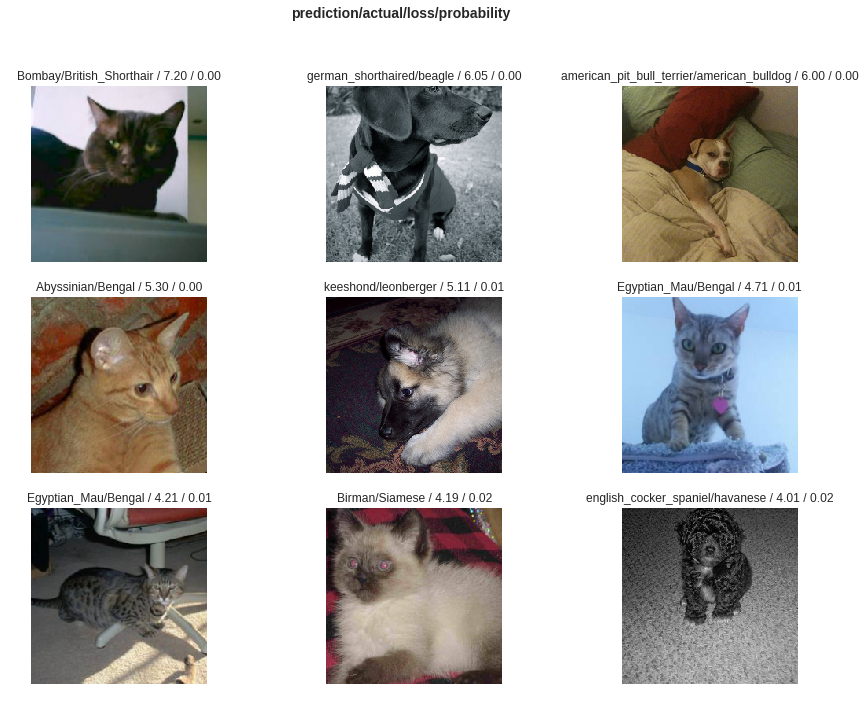

In [22]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

NOTE:  We will learn about loss functions shortly. But the idea is  that **loss function tells you how good was your prediction compared to ground truth**.
Specifically, that means if you predicted one class of cat with great confidence.

For example, if you confidently predicted this is a Berman cat, but actually it was wrong. It was a Ragdoll cat. Then it is going to have a very high loss because you were very confident about the wrong answer.

So by plotting the top losses, we are going to plot images which were most confident about the prediction but were wrong.

In [23]:
doc(interp.plot_top_losses) 

### The confusion matrix

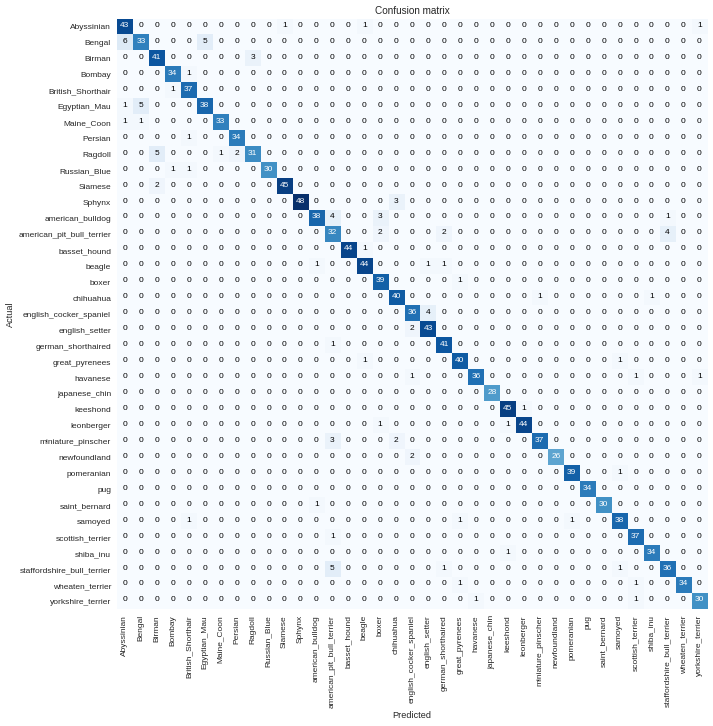

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

NOTE:  It shows you for every actual breed of dog or cat:
- how many time model predicted to be of that dog or cat.
- when it is  pretty accurate, it shows darker diagonal line, with little lighter numbers for some other wrong combinations.

If you have got lots of classes, don’t use a confusion matrix. instead, use named function by fastai called most_confused().  See below.

In [25]:
interp.most_confused(min_val=2)

[('Bengal', 'Abyssinian', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Egyptian_Mau', 'Bengal', 5),
 ('Ragdoll', 'Birman', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('english_cocker_spaniel', 'english_setter', 4),
 ('Birman', 'Ragdoll', 3),
 ('Sphynx', 'chihuahua', 3),
 ('american_bulldog', 'boxer', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('Ragdoll', 'Persian', 2),
 ('Siamese', 'Birman', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('american_pit_bull_terrier', 'german_shorthaired', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('newfoundland', 'english_cocker_spaniel', 2)]

NOTE:  `most_confused()` function will simply grab out from the confusion matrix the most confused combinations of predicted and actual categories, that it got wrong most often.

Example: `('Ragdoll', 'Birman', 5)`, 
- actual: `Ragdoll`
- prediction: `Birman`
- this wrong combination (actual v.s. prediction )happened 8 times.

## Inference

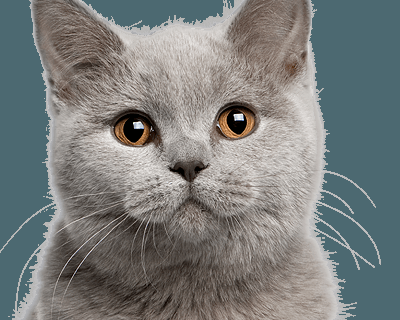

In [30]:
img = open_image('/content/sample_data/very_nicecat.png')
img

In [31]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category British_Shorthair

## Unfreezing, fine-tuning, and learning rates

NOTE:  We can make our model better by Fine-tuning it.

So far we have fitted 4 epochs and it ran pretty quickly. Why is that so? Because we used a little trick (called transfer learning).
These deep learning models have many layers. We will learn later about what layers are. But for now, understand that it goes through a lot of computations.

What did we do?
We added few extra layers at the end of architecture, and we only trained those. We left most of the early layers as they were. This is called freezing layers i.e weights of the layers. So that was really fast.

If we want to build a model, that is quite similar to the original retrained model, in this case, similar to Imagenet data that works pretty well.

What we really want to do now?
We want to go back and train the whole model. So this is why we always use this 2-state process.

When we call fit or fit_one_cycle() on a create_cnn, it will just fine tune these extra layers at the end, and run very fast.  It will basically never overfit, but to really get it good, you have to call this instruction `learn.unfreeze`.

**`unfreeze()` says train the whole model.**


Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.552917,0.348039,0.106225,02:18


NOTE:  After unfreezing the layers, we  call `fit_one_cycle(1)` with only one cycle, and the error rate got really worse!

Why  has that happened?

In order to understand why, we are actually going to have to learn more about exactly what's going on behind the scenes. So let's start out by trying to get an intuitive understanding of what's going on behind the scenes. We are going to do it by looking at pictures.

[visualizing and understanding convolutional networks](https://www.youtube.com/watch?v=BWWm4AzsdLk&feature=youtu.be&t=4588)


This is why our attempt to fine-tune this model didn't work because by default, it trains all the layers at the same speed which is to say it will update those things representing diagonal lines and gradients just as much as it tries to update the things that represent the exact specifics of what an eyeball looks like, so we have to change that.

To change it, we first of all need to go back to where we were before. We just broke this model, much worse than it started out. So if we just go:

In [0]:
learn.load('/content/sample_data/stage-1');

### Learning Rate Finder
Let's run learning rate finder. We are learning about what that is next week, but for now, just know this is the thing that figures out what is the fastest I can train this neural network at without making it zip off the rails and get blown apart.

[learning rates after unfreezing](https://www.youtube.com/watch?v=BWWm4AzsdLk&feature=youtu.be&t=1h25m20s)

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


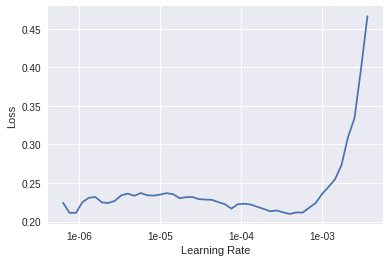

In [36]:
learn.recorder.plot()

NOTE:  The learning rate basically says how quickly are we updating the parameters in our model. The** x-axis** one here shows me what happens as I increase the learning rate. The** y-axis** shows what the loss is. So you can see, once the learning rate gets passed 10-4, our loss gets worse.

Our learning rate default is **0.003 = 10-3**. 
So you can see why our loss got worse. 

Because we are trying to fine-tune things now, we can’t use such a high learning rate. So based on the learning rate finder, we tried to pick something well before it started getting worse. So Jeremy decided to pick **1e-6**. But there’s no point training all the layers at that rate because we know that the later layers worked just fine before when we were training much more quickly. So what we can actually do is we can pass a range of learning rates to learn.fit_one_cycle. And we do it like this:
`max_lr=slice(1e-6,1e-4))`; see below.

In [37]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.234264,0.199656,0.062246,02:23
1,0.215669,0.196314,0.058863,02:24


NOTE:   `slice` is Python keyword, **it takes a start value and a stop value**.  Basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that between those two values equally. 

**So for the `slice` method, the stop paremeter should be 10 times smaller than the start parameter. i.e.: `max_lr=slice(1e-6,1e-4)`**

That's a pretty accurate model!

NOTE: Begin to train the model while increasing the learning rate from a very low to a very large one, stop when the loss starts to really get out of control. Plot the losses against the learning rates and pick a value a bit before the minimum, where the loss still improves. [Here for instance, anything between 10−2 and 3×10−2 seems like a good idea.](https://sgugger.github.io/the-1cycle-policy.html)

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [39]:
#learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn = cnn_learner(data, models.resnet50, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 83008462.20it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


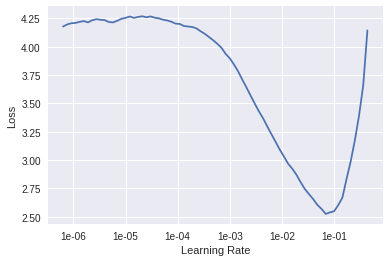

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.719108,0.264773,0.087957,03:50
1,0.403418,0.215579,0.075778,03:46
2,0.356369,0.198025,0.067659,03:44
3,0.284261,0.182847,0.055480,03:46
4,0.213054,0.187065,0.061570,03:45
5,0.162009,0.147724,0.046008,03:47
6,0.115398,0.136711,0.041949,03:48
7,0.097266,0.139354,0.040595,03:48


In [0]:
learn.save('/content/sample_data/stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.105011,0.143889,0.043978,04:28
1,0.094000,0.145930,0.044655,04:23
2,0.070311,0.146805,0.041949,04:23


If it doesn't, you can always go back to your previous model by reloading the saved stage.

In [0]:
learn.load('/content/sample_data/stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [45]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 9),
 ('Ragdoll', 'Birman', 5),
 ('Bengal', 'Abyssinian', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Siamese', 'Birman', 2),
 ('Sphynx', 'Abyssinian', 2),
 ('beagle', 'basset_hound', 2),
 ('leonberger', 'keeshond', 2),
 ('miniature_pinscher', 'american_pit_bull_terrier', 2),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 2)]

## Inference with resnet50


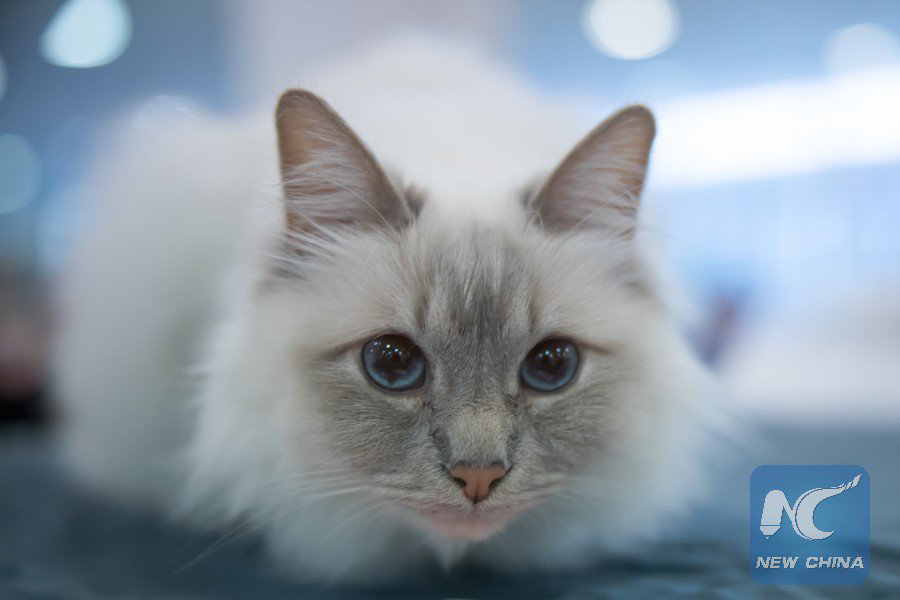

In [46]:
img = open_image('/content/sample_data/nice-cat.jpg')
img

In [47]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category Ragdoll

## Other databunch formats using as an example the MNIST dataset

Loading labels from:
- from_folder
- from_csv
- from_re (regular expressions)
- from_name_func
- from lists

### Getting the MNIST dataset

In [48]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/root/.fastai/data/mnist_sample')

In [49]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_sample/train'),
 PosixPath('/root/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/root/.fastai/data/mnist_sample/valid')]

In [50]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/mnist_sample/train/7'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3')]

### Databunch from folder

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

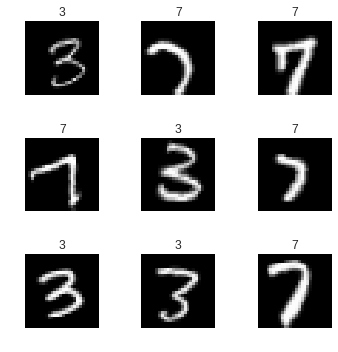

In [52]:
data.show_batch(rows=3, figsize=(5,5))

In [53]:
#learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 74794611.39it/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.159567,0.079648,0.972522,00:28
1,0.095144,0.040813,0.985280,00:24


### Databunch from cav

In [54]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

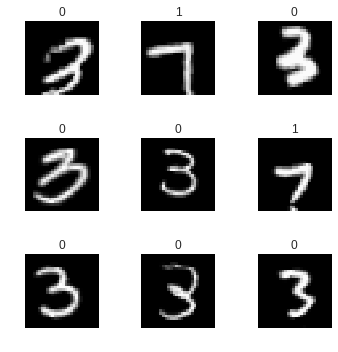

In [56]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

### Databunch from a Pandas data frame

In [57]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

### Databunch from a function

In [58]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/root/.fastai/data/mnist_sample/train/3/7463.png'),
 PosixPath('/root/.fastai/data/mnist_sample/train/3/21102.png')]

In [59]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

### Databunch using regex

In [60]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

### Databunch using lists

In [61]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [62]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [63]:
doc(ImageDataBunch.from_lists)

# Summary
Steps for creating an image classifier:

- Import data - data = `ImageDataBunch.from_name_re`(...)
- Build model - learn = `learn = cnn_learner`(...)
- Unfreeze model - `learn.unfreeze`(...)
- Find good learning rate(s) - `learn.lr_find`(...)
- Train model again `learn.fit_one_cycle`(...)
- Analyze the results `ClassificationInterpretation.from_learner`(...)
- Inference
  - load an image: `img = open_image()`
  - run the prediction: `pred_class,pred_idx,outputs = learn.predict(img)
pred_class`


# Regular Expressions

- [Parsing File Names - Undestanding Regular Expressions](https://medium.com/@youknowjamest/parsing-file-names-using-regular-expressions-3e85d64deb69)

- [Visualizing Regular Expressions](https://regexr.com/)

- [Interactive Tutorial to Learn Regex](https://regexone.com/)

- [Beginners Tutorial for Regex](https://www.analyticsvidhya.com/blog/2015/06/regular-expression-python/)

# Assignment

- Run this notebook!!! and have a general understanding regarding the code
- Get your own dataset

## Ref.:
[Creating your own dataset from Google images](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb)


[Tips for building large image datasets](https://forums.fast.ai/t/tips-for-building-large-image-datasets/26688)